In [1]:
from os.path import join as pjoin

from common.skeleton import Skeleton
import numpy as np
import os
from common.quaternion import *
from paramUtil import *

import torch
from tqdm import tqdm
import os

In [2]:
def uniform_skeleton(positions, target_offset):
    src_skel = Skeleton(n_raw_offsets, kinematic_chain, 'cpu')
    src_offset = src_skel.get_offsets_joints(torch.from_numpy(positions[0]))
    src_offset = src_offset.numpy()
    tgt_offset = target_offset.numpy()
    # print(src_offset)
    # print(tgt_offset)
    '''Calculate Scale Ratio as the ratio of legs'''
    src_leg_len = np.abs(src_offset[l_idx1]).max() + np.abs(src_offset[l_idx2]).max()
    tgt_leg_len = np.abs(tgt_offset[l_idx1]).max() + np.abs(tgt_offset[l_idx2]).max()

    scale_rt = tgt_leg_len / src_leg_len
    # print(scale_rt)
    src_root_pos = positions[:, 0]
    tgt_root_pos = src_root_pos * scale_rt

    '''Inverse Kinematics'''
    quat_params = src_skel.inverse_kinematics_np(positions, face_joint_indx)
    # print(quat_params.shape)

    '''Forward Kinematics'''
    src_skel.set_offset(target_offset)
    new_joints = src_skel.forward_kinematics_np(quat_params, tgt_root_pos)
    return new_joints


In [3]:
def process_file(positions, feet_thre):
    # (seq_len, joints_num, 3)
    #     '''Down Sample'''
    #     positions = positions[::ds_num]

    '''Uniform Skeleton'''
    positions = uniform_skeleton(positions, tgt_offsets)

    '''Put on Floor'''
    floor_height = positions.min(axis=0).min(axis=0)[1]
    positions[:, :, 1] -= floor_height
    #     print(floor_height)

    #     plot_3d_motion("./positions_1.mp4", kinematic_chain, positions, 'title', fps=20)

    '''XZ at origin'''
    root_pos_init = positions[0]
    root_pose_init_xz = root_pos_init[0] * np.array([1, 0, 1])
    positions = positions - root_pose_init_xz

    # '''Move the first pose to origin '''
    # root_pos_init = positions[0]
    # positions = positions - root_pos_init[0]

    '''All initially face Z+'''
    r_hip, l_hip, sdr_r, sdr_l = face_joint_indx
    across1 = root_pos_init[r_hip] - root_pos_init[l_hip]
    across2 = root_pos_init[sdr_r] - root_pos_init[sdr_l]
    across = across1 + across2
    across = across / np.sqrt((across ** 2).sum(axis=-1))[..., np.newaxis]

    # forward (3,), rotate around y-axis
    forward_init = np.cross(np.array([[0, 1, 0]]), across, axis=-1)
    # forward (3,)
    forward_init = forward_init / np.sqrt((forward_init ** 2).sum(axis=-1))[..., np.newaxis]

    #     print(forward_init)

    target = np.array([[0, 0, 1]])
    root_quat_init = qbetween_np(forward_init, target)
    root_quat_init = np.ones(positions.shape[:-1] + (4,)) * root_quat_init

    positions_b = positions.copy()

    positions = qrot_np(root_quat_init, positions)

    #  plot_3d_motion("./positions_2.mp4", kinematic_chain, positions, 'title', fps=20)

    '''New ground truth positions'''
    global_positions = positions.copy()

    # plt.plot(positions_b[:, 0, 0], positions_b[:, 0, 2], marker='*')
    # plt.plot(positions[:, 0, 0], positions[:, 0, 2], marker='o', color='r')
    # plt.xlabel('x')
    # plt.ylabel('z')
    # plt.axis('equal')
    # plt.show()

    """ Get Foot Contacts """

    def foot_detect(positions, thres):
        velfactor, heightfactor = np.array([thres, thres]), np.array([3.0, 2.0])

        feet_l_x = (positions[1:, fid_l, 0] - positions[:-1, fid_l, 0]) ** 2
        feet_l_y = (positions[1:, fid_l, 1] - positions[:-1, fid_l, 1]) ** 2
        feet_l_z = (positions[1:, fid_l, 2] - positions[:-1, fid_l, 2]) ** 2
        #     feet_l_h = positions[:-1,fid_l,1]
        #     feet_l = (((feet_l_x + feet_l_y + feet_l_z) < velfactor) & (feet_l_h < heightfactor)).astype(np.float)
        feet_l = ((feet_l_x + feet_l_y + feet_l_z) < velfactor).astype(np.float32)

        feet_r_x = (positions[1:, fid_r, 0] - positions[:-1, fid_r, 0]) ** 2
        feet_r_y = (positions[1:, fid_r, 1] - positions[:-1, fid_r, 1]) ** 2
        feet_r_z = (positions[1:, fid_r, 2] - positions[:-1, fid_r, 2]) ** 2
        #     feet_r_h = positions[:-1,fid_r,1]
        #     feet_r = (((feet_r_x + feet_r_y + feet_r_z) < velfactor) & (feet_r_h < heightfactor)).astype(np.float)
        feet_r = (((feet_r_x + feet_r_y + feet_r_z) < velfactor)).astype(np.float32)
        return feet_l, feet_r
    #
    feet_l, feet_r = foot_detect(positions, feet_thre)
    # feet_l, feet_r = foot_detect(positions, 0.002)

    '''Quaternion and Cartesian representation'''
    r_rot = None

    def get_rifke(positions):
        '''Local pose'''
        positions[..., 0] -= positions[:, 0:1, 0]
        positions[..., 2] -= positions[:, 0:1, 2]
        '''All pose face Z+'''
        positions = qrot_np(np.repeat(r_rot[:, None], positions.shape[1], axis=1), positions)
        return positions

    def get_quaternion(positions):
        skel = Skeleton(n_raw_offsets, kinematic_chain, "cpu")
        # (seq_len, joints_num, 4)
        quat_params = skel.inverse_kinematics_np(positions, face_joint_indx, smooth_forward=False)

        '''Fix Quaternion Discontinuity'''
        quat_params = qfix(quat_params)
        # (seq_len, 4)
        r_rot = quat_params[:, 0].copy()
        #     print(r_rot[0])
        '''Root Linear Velocity'''
        # (seq_len - 1, 3)
        velocity = (positions[1:, 0] - positions[:-1, 0]).copy()
        #     print(r_rot.shape, velocity.shape)
        velocity = qrot_np(r_rot[1:], velocity)
        '''Root Angular Velocity'''
        # (seq_len - 1, 4)
        r_velocity = qmul_np(r_rot[1:], qinv_np(r_rot[:-1]))
        quat_params[1:, 0] = r_velocity
        # (seq_len, joints_num, 4)
        return quat_params, r_velocity, velocity, r_rot

    def get_cont6d_params(positions):
        skel = Skeleton(n_raw_offsets, kinematic_chain, "cpu")
        # (seq_len, joints_num, 4)
        quat_params = skel.inverse_kinematics_np(positions, face_joint_indx, smooth_forward=True)

        '''Quaternion to continuous 6D'''
        cont_6d_params = quaternion_to_cont6d_np(quat_params)
        # (seq_len, 4)
        r_rot = quat_params[:, 0].copy()
        #     print(r_rot[0])
        '''Root Linear Velocity'''
        # (seq_len - 1, 3)
        velocity = (positions[1:, 0] - positions[:-1, 0]).copy()
        #     print(r_rot.shape, velocity.shape)
        velocity = qrot_np(r_rot[1:], velocity)
        '''Root Angular Velocity'''
        # (seq_len - 1, 4)
        r_velocity = qmul_np(r_rot[1:], qinv_np(r_rot[:-1]))
        # (seq_len, joints_num, 4)
        return cont_6d_params, r_velocity, velocity, r_rot

    cont_6d_params, r_velocity, velocity, r_rot = get_cont6d_params(positions)
    positions = get_rifke(positions)

    #     trejec = np.cumsum(np.concatenate([np.array([[0, 0, 0]]), velocity], axis=0), axis=0)
    #     r_rotations, r_pos = recover_ric_glo_np(r_velocity, velocity[:, [0, 2]])

    # plt.plot(positions_b[:, 0, 0], positions_b[:, 0, 2], marker='*')
    # plt.plot(ground_positions[:, 0, 0], ground_positions[:, 0, 2], marker='o', color='r')
    # plt.plot(trejec[:, 0], trejec[:, 2], marker='^', color='g')
    # plt.plot(r_pos[:, 0], r_pos[:, 2], marker='s', color='y')
    # plt.xlabel('x')
    # plt.ylabel('z')
    # plt.axis('equal')
    # plt.show()

    '''Root height'''
    root_y = positions[:, 0, 1:2]

    '''Root rotation and linear velocity'''
    # (seq_len-1, 1) rotation velocity along y-axis
    # (seq_len-1, 2) linear velovity on xz plane
    r_velocity = np.arcsin(r_velocity[:, 2:3])
    l_velocity = velocity[:, [0, 2]]
    #     print(r_velocity.shape, l_velocity.shape, root_y.shape)
    root_data = np.concatenate([r_velocity, l_velocity, root_y[:-1]], axis=-1)

    '''Get Joint Rotation Representation'''
    # (seq_len, (joints_num-1) *6) quaternion for skeleton joints
    rot_data = cont_6d_params[:, 1:].reshape(len(cont_6d_params), -1)

    '''Get Joint Rotation Invariant Position Represention'''
    # (seq_len, (joints_num-1)*3) local joint position
    ric_data = positions[:, 1:].reshape(len(positions), -1)

    '''Get Joint Velocity Representation'''
    # (seq_len-1, joints_num*3)
    local_vel = qrot_np(np.repeat(r_rot[:-1, None], global_positions.shape[1], axis=1),
                        global_positions[1:] - global_positions[:-1])
    local_vel = local_vel.reshape(len(local_vel), -1)

    data = root_data
    data = np.concatenate([data, ric_data[:-1]], axis=-1)
    data = np.concatenate([data, rot_data[:-1]], axis=-1)
    #     print(data.shape, local_vel.shape)
    data = np.concatenate([data, local_vel], axis=-1)
    data = np.concatenate([data, feet_l, feet_r], axis=-1)

    return data, global_positions, positions, l_velocity


In [40]:
def process_file_abs_root(positions, feet_thre):
    '''
    root information (first 3 values) is absolute instead of relative.
    '''
    # (seq_len, joints_num, 3)
    #     '''Down Sample'''
    #     positions = positions[::ds_num]

    '''Uniform Skeleton'''
    positions = uniform_skeleton(positions, tgt_offsets)

    '''Put on Floor'''
    floor_height = positions.min(axis=0).min(axis=0)[1]
    positions[:, :, 1] -= floor_height
    #     print(floor_height)

    #     plot_3d_motion("./positions_1.mp4", kinematic_chain, positions, 'title', fps=20)

    '''XZ at origin'''
    root_pos_init = positions[0]
    root_pose_init_xz = root_pos_init[0] * np.array([1, 0, 1])
    positions = positions - root_pose_init_xz

    # '''Move the first pose to origin '''
    # root_pos_init = positions[0]
    # positions = positions - root_pos_init[0]

    '''All initially face Z+'''
    r_hip, l_hip, sdr_r, sdr_l = face_joint_indx
    across1 = root_pos_init[r_hip] - root_pos_init[l_hip]
    across2 = root_pos_init[sdr_r] - root_pos_init[sdr_l]
    across = across1 + across2
    across = across / np.sqrt((across ** 2).sum(axis=-1))[..., np.newaxis]

    # forward (3,), rotate around y-axis
    forward_init = np.cross(np.array([[0, 1, 0]]), across, axis=-1)
    # forward (3,)
    forward_init = forward_init / np.sqrt((forward_init ** 2).sum(axis=-1))[..., np.newaxis]

    #     print(forward_init)

    target = np.array([[0, 0, 1]])
    root_quat_init = qbetween_np(forward_init, target)
    root_quat_init = np.ones(positions.shape[:-1] + (4,)) * root_quat_init

    positions_b = positions.copy()

    positions = qrot_np(root_quat_init, positions)

    # plot_3d_motion("./positions_2.mp4", kinematic_chain, positions, 'title', fps=20)

    '''New ground truth positions'''
    global_positions = positions.copy()

#     plt.plot(positions_b[:, 0, 0], positions_b[:, 0, 2], marker='*')
#     plt.plot(positions[:, 0, 0], positions[:, 0, 2], marker='o', color='r')
#     plt.xlabel('x')
#     plt.ylabel('z')
#     plt.axis('equal')
#     plt.show()

    """ Get Foot Contacts """

    def foot_detect(positions, thres):
        velfactor, heightfactor = np.array([thres, thres]), np.array([3.0, 2.0])

        feet_l_x = (positions[1:, fid_l, 0] - positions[:-1, fid_l, 0]) ** 2
        feet_l_y = (positions[1:, fid_l, 1] - positions[:-1, fid_l, 1]) ** 2
        feet_l_z = (positions[1:, fid_l, 2] - positions[:-1, fid_l, 2]) ** 2
        #     feet_l_h = positions[:-1,fid_l,1]
        #     feet_l = (((feet_l_x + feet_l_y + feet_l_z) < velfactor) & (feet_l_h < heightfactor)).astype(np.float)
        feet_l = ((feet_l_x + feet_l_y + feet_l_z) < velfactor).astype(np.float32)

        feet_r_x = (positions[1:, fid_r, 0] - positions[:-1, fid_r, 0]) ** 2
        feet_r_y = (positions[1:, fid_r, 1] - positions[:-1, fid_r, 1]) ** 2
        feet_r_z = (positions[1:, fid_r, 2] - positions[:-1, fid_r, 2]) ** 2
        #     feet_r_h = positions[:-1,fid_r,1]
        #     feet_r = (((feet_r_x + feet_r_y + feet_r_z) < velfactor) & (feet_r_h < heightfactor)).astype(np.float)
        feet_r = (((feet_r_x + feet_r_y + feet_r_z) < velfactor)).astype(np.float32)
        return feet_l, feet_r
    #
    feet_l, feet_r = foot_detect(positions, feet_thre)
    # feet_l, feet_r = foot_detect(positions, 0.002)

    '''Quaternion and Cartesian representation'''
    r_rot = None

    def get_rifke(positions):
        '''Local pose'''
        positions[..., 0] -= positions[:, 0:1, 0]
        positions[..., 2] -= positions[:, 0:1, 2]
        '''All pose face Z+'''
        positions = qrot_np(np.repeat(r_rot[:, None], positions.shape[1], axis=1), positions)
        return positions

    def get_quaternion(positions):
        skel = Skeleton(n_raw_offsets, kinematic_chain, "cpu")
        # (seq_len, joints_num, 4)
        quat_params = skel.inverse_kinematics_np(positions, face_joint_indx, smooth_forward=False)

        '''Fix Quaternion Discontinuity'''
        quat_params = qfix(quat_params)
        # (seq_len, 4)
        r_rot = quat_params[:, 0].copy()
        #     print(r_rot[0])
        '''Root Linear Velocity'''
        # (seq_len - 1, 3)
        velocity = (positions[1:, 0] - positions[:-1, 0]).copy()
        #     print(r_rot.shape, velocity.shape)
        velocity = qrot_np(r_rot[1:], velocity)
        '''Root Angular Velocity'''
        # (seq_len - 1, 4)
        r_velocity = qmul_np(r_rot[1:], qinv_np(r_rot[:-1]))
        quat_params[1:, 0] = r_velocity
        # (seq_len, joints_num, 4)
        return quat_params, r_velocity, velocity, r_rot

    def get_cont6d_params(positions):
        skel = Skeleton(n_raw_offsets, kinematic_chain, "cpu")
        # (seq_len, joints_num, 4)
        quat_params = skel.inverse_kinematics_np(positions, face_joint_indx, smooth_forward=True)

        '''Quaternion to continuous 6D'''
        cont_6d_params = quaternion_to_cont6d_np(quat_params)
        # (seq_len, 4)
        r_rot = quat_params[:, 0].copy()
        #     print(r_rot[0])
        '''Root Linear Velocity'''
        # (seq_len - 1, 3)
        velocity = (positions[1:, 0] - positions[:-1, 0]).copy()
        #     print(r_rot.shape, velocity.shape)
        velocity = qrot_np(r_rot[1:], velocity)
        '''Root Angular Velocity'''
        # (seq_len - 1, 4)
        r_velocity = qmul_np(r_rot[1:], qinv_np(r_rot[:-1]))
        # (seq_len, joints_num, 4)
        return cont_6d_params, r_velocity, velocity, r_rot

    cont_6d_params, r_velocity, velocity, r_rot = get_cont6d_params(positions)
    positions = get_rifke(positions)

#     trejec = np.cumsum(np.concatenate([np.array([[0, 0, 0]]), velocity], axis=0), axis=0)
# #     r_rotations, r_pos = recover_ric_glo_np(r_velocity, velocity[:, [0, 2]])

# #     plt.plot(positions_b[:, 0, 0], positions_b[:, 0, 2], marker='*')
#     plt.plot(positions[:, 0, 0], positions[:, 0, 2], marker='*')
# #     plt.plot(ground_positions[:, 0, 0], ground_positions[:, 0, 2], marker='o', color='r')
#     plt.plot(trejec[:, 0], trejec[:, 2], marker='^', color='g')
# #     plt.plot(r_pos[:, 0], r_pos[:, 2], marker='s', color='y')
#     plt.xlabel('x')
#     plt.ylabel('z')
#     plt.axis('equal')
#     plt.show()
#     import pdb; pdb.set_trace()

    '''Root height'''
    root_y = positions[:, 0, 1:2]

    '''Root rotation and linear velocity'''
    # (seq_len-1, 1) rotation velocity along y-axis
    # (seq_len-1, 2) linear velovity on xz plane
    r_velocity = np.arcsin(r_velocity[:, 2:3])
    l_velocity = velocity[:, [0, 2]]
    #     print(r_velocity.shape, l_velocity.shape, root_y.shape)
    root_data = np.concatenate([r_velocity, l_velocity, root_y[:-1]], axis=-1)

    '''Get Joint Rotation Representation'''
    # (seq_len, (joints_num-1) *6) quaternion for skeleton joints
    rot_data = cont_6d_params[:, 1:].reshape(len(cont_6d_params), -1)

    '''Get Joint Rotation Invariant Position Represention'''
    # (seq_len, (joints_num-1)*3) local joint position
    ric_data = positions[:, 1:].reshape(len(positions), -1)

    '''Get Joint Velocity Representation'''
    # (seq_len-1, joints_num*3)
    local_vel = qrot_np(np.repeat(r_rot[:-1, None], global_positions.shape[1], axis=1),
                        global_positions[1:] - global_positions[:-1])
    local_vel = local_vel.reshape(len(local_vel), -1)

    data = root_data
    data = np.concatenate([data, ric_data[:-1]], axis=-1)
    data = np.concatenate([data, rot_data[:-1]], axis=-1)
    #     print(data.shape, local_vel.shape)
    data = np.concatenate([data, local_vel], axis=-1)
    data = np.concatenate([data, feet_l, feet_r], axis=-1)

    return data, global_positions, positions, l_velocity


In [28]:
# Recover global angle and positions for rotation data
# root_rot_velocity (B, seq_len, 1)
# root_linear_velocity (B, seq_len, 2)
# root_y (B, seq_len, 1)
# ric_data (B, seq_len, (joint_num - 1)*3)
# rot_data (B, seq_len, (joint_num - 1)*6)
# local_velocity (B, seq_len, joint_num*3)
# foot contact (B, seq_len, 4)
def recover_root_rot_pos(data, return_rot_ang=False):
    rot_vel = data[..., 0]
    r_rot_ang = torch.zeros_like(rot_vel).to(data.device)
    '''Get Y-axis rotation from rotation velocity'''
    r_rot_ang[..., 1:] = rot_vel[..., :-1]
    r_rot_ang = torch.cumsum(r_rot_ang, dim=-1)

    r_rot_quat = torch.zeros(data.shape[:-1] + (4,)).to(data.device)
    r_rot_quat[..., 0] = torch.cos(r_rot_ang)
    r_rot_quat[..., 2] = torch.sin(r_rot_ang)

    r_pos = torch.zeros(data.shape[:-1] + (3,)).to(data.device)
    r_pos[..., 1:, [0, 2]] = data[..., :-1, 1:3]
    '''Add Y-axis rotation to root position'''
    r_pos = qrot(qinv(r_rot_quat), r_pos)

    r_pos = torch.cumsum(r_pos, dim=-2)

    r_pos[..., 1] = data[..., 3]

    if return_rot_ang:
        return r_rot_quat, r_pos, r_rot_ang
    return r_rot_quat, r_pos


def recover_from_rot(data, joints_num, skeleton):
    r_rot_quat, r_pos = recover_root_rot_pos(data)

    r_rot_cont6d = quaternion_to_cont6d(r_rot_quat)

    start_indx = 1 + 2 + 1 + (joints_num - 1) * 3
    end_indx = start_indx + (joints_num - 1) * 6
    cont6d_params = data[..., start_indx:end_indx]
    #     print(r_rot_cont6d.shape, cont6d_params.shape, r_pos.shape)
    cont6d_params = torch.cat([r_rot_cont6d, cont6d_params], dim=-1)
    cont6d_params = cont6d_params.view(-1, joints_num, 6)

    positions = skeleton.forward_kinematics_cont6d(cont6d_params, r_pos)

    return positions


def recover_from_ric(data, joints_num):
    r_rot_quat, r_pos = recover_root_rot_pos(data)
    positions = data[..., 4:(joints_num - 1) * 3 + 4]
    positions = positions.view(positions.shape[:-1] + (-1, 3))

    '''Add Y-axis rotation to local joints'''
    positions = qrot(qinv(r_rot_quat[..., None, :]).expand(positions.shape[:-1] + (4,)), positions)

    '''Add root XZ to joints'''
    positions[..., 0] += r_pos[..., 0:1]
    positions[..., 2] += r_pos[..., 2:3]

    '''Concate root and joints'''
    positions = torch.cat([r_pos.unsqueeze(-2), positions], dim=-2)

    return positions

In [6]:
# The given data is used to double check if you are on the right track.
reference1 = np.load('./HumanML3D/new_joints/012314.npy')
reference2 = np.load('./HumanML3D/new_joint_vecs/012314.npy')

  1%|▍                                      | 358/29232 [00:17<23:11, 20.75it/s]

011059.npy
cannot reshape array of size 0 into shape (0,newaxis)


 85%|███████████████████████████████▌     | 24903/29232 [20:17<03:26, 21.01it/s]

M011059.npy
cannot reshape array of size 0 into shape (0,newaxis)


 89%|████████████████████████████████▊    | 25957/29232 [21:12<02:31, 21.59it/s]

009707.npy
cannot reshape array of size 0 into shape (0,newaxis)


 98%|████████████████████████████████████▏| 28591/29232 [23:25<00:31, 20.05it/s]

M009707.npy
cannot reshape array of size 0 into shape (0,newaxis)


100%|█████████████████████████████████████| 29232/29232 [23:57<00:00, 20.34it/s]


Total clips: 29232, Frames: 4117392, Duration: 3431.160000m


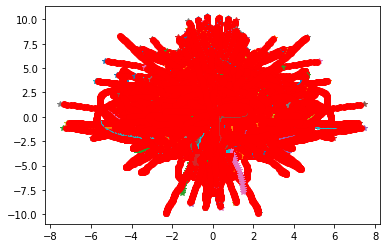

In [41]:
'''
For HumanML3D Dataset
'''

if __name__ == "__main__":
    example_id = "000021"
    # Lower legs
    l_idx1, l_idx2 = 5, 8
    # Right/Left foot
    fid_r, fid_l = [8, 11], [7, 10]
    # Face direction, r_hip, l_hip, sdr_r, sdr_l
    face_joint_indx = [2, 1, 17, 16]
    # l_hip, r_hip
    r_hip, l_hip = 2, 1
    joints_num = 22
    # ds_num = 8
    data_dir = './joints/'
    save_dir1 = './HumanML3D/new_joints_abs_3d/'      # './HumanML3D/new_joints/'
    save_dir2 = './HumanML3D/new_joint_vecs_abs_3d/'  # './HumanML3D/new_joint_vecs/'
    
    os.makedirs(save_dir1, exist_ok=True)
    os.makedirs(save_dir2, exist_ok=True)

    n_raw_offsets = torch.from_numpy(t2m_raw_offsets)
    kinematic_chain = t2m_kinematic_chain

    # Get offsets of target skeleton
    example_data = np.load(os.path.join(data_dir, example_id + '.npy'))
    example_data = example_data.reshape(len(example_data), -1, 3)
    example_data = torch.from_numpy(example_data)
    tgt_skel = Skeleton(n_raw_offsets, kinematic_chain, 'cpu')
    # (joints_num, 3)
    tgt_offsets = tgt_skel.get_offsets_joints(example_data[0])
    # print(tgt_offsets)

    source_list = os.listdir(data_dir)
    frame_num = 0
    for source_file in tqdm(source_list):
        source_data = np.load(os.path.join(data_dir, source_file))[:, :joints_num]
        try:
#             data, ground_positions, positions, l_velocity = process_file(source_data, 0.002)
            ### compute absoluate root information instead of relative, ignore rec_ric_data
            data, ground_positions, positions, l_velocity = process_file_abs_root(source_data, 0.002)
            rec_ric_data = recover_from_ric(torch.from_numpy(data).unsqueeze(0).float(), joints_num)
            r_rot_quat, r_pos, rot_ang = recover_root_rot_pos(torch.from_numpy(data), return_rot_ang=True)
            new_data = data.copy()
            new_data[:, 0] = rot_ang
            new_data[:, [1, 2]] = r_pos[:, [0,2]]
            ###
            np.save(pjoin(save_dir1, source_file), rec_ric_data.squeeze().numpy())
#             np.save(pjoin(save_dir2, source_file), data)
            np.save(pjoin(save_dir2, source_file), new_data)
            frame_num += data.shape[0]
            
            # plt.plot(ground_positions[:, 0, 0], ground_positions[:, 0, 2], marker='*')
            # plt.plot(new_data[:, 1], new_data[:, 2], marker='o', color='r')
#             plt.plot(r_pos[:, 0], r_pos[:, 2], marker='o', color='r')
#             plt.xlabel('x')
#             plt.ylabel('z')
#             plt.axis('equal')
#             plt.show()
            # ground_positions[:, 0, [0,2]]
            # new_data[:, [1,2]]
#             import pdb; pdb.set_trace()
            
        except Exception as e:
            print(source_file)
            print(e)
#         print(source_file)
#         break
#         import pdb; pdb.set_trace()

    print('Total clips: %d, Frames: %d, Duration: %fm' %
          (len(source_list), frame_num, frame_num / 20 / 60))

### Check if your data is correct. If it's aligned with the given reference, then it is right

In [42]:
reference1_1 = np.load('./HumanML3D/new_joints/012314.npy')
reference2_1 = np.load('./HumanML3D/new_joint_vecs/012314.npy')

In [43]:
abs(reference1 - reference1_1).sum()

0.0

In [44]:
abs(reference2 - reference2_1).sum()

0.0